# Lesson 6: Essay Writer

In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

memory = SqliteSaver.from_conn_string(":memory:")

In [3]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [4]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [5]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [6]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [7]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [8]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [9]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [10]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [11]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [12]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [13]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [14]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [15]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [16]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [17]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [18]:
builder = StateGraph(AgentState)

In [19]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [20]:
builder.set_entry_point("planner")

In [21]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)


In [22]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [23]:
graph = builder.compile(checkpointer=memory)

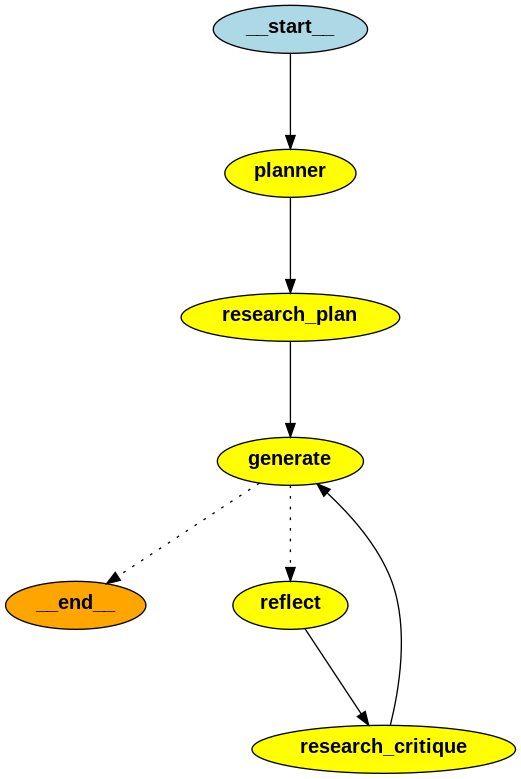

In [24]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [25]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)

{'planner': {'plan': 'Title: Exploring the Differences Between Langchain and Langsmith\n\nI. Introduction\n    A. Brief overview of Langchain and Langsmith\n    B. Thesis statement: Despite similarities in their names, Langchain and Langsmith are distinct concepts with unique characteristics and applications.\n\nII. Langchain\n    A. Definition and origin\n    B. Key features and functionalities\n    C. Use cases and examples\n    D. Advantages and limitations\n\nIII. Langsmith\n    A. Definition and background\n    B. Core principles and methodologies\n    C. Applications and significance\n    D. Comparison with Langchain\n\nIV. Contrasting Langchain and Langsmith\n    A. Differentiation in purpose and scope\n    B. Variances in technology and implementation\n    C. Impact on language learning and development\n\nV. Conclusion\n    A. Recap of the main points\n    B. Emphasize the importance of understanding the distinctions between Langchain and Langsmith\n    C. Closing thoughts on t

{'reflect': {'critique': 'Overall, your essay provides a clear and concise overview of the differences between Langchain and Langsmith in the context of language model development. Here are some suggestions to enhance your submission:\n\n1. **Depth and Examples**: While you have explained the roles of Langchain and Langsmith effectively, consider providing more in-depth examples or case studies to illustrate how these tools are used in real-world scenarios. This will help readers better understand the practical applications of Langchain and Langsmith.\n\n2. **Comparison**: To further emphasize the disparities between Langchain and Langsmith, consider including a section that directly compares and contrasts the key features, functionalities, and benefits of each tool. This will highlight their unique characteristics and help readers differentiate between them more clearly.\n\n3. **Recommendations for Usage**: It would be beneficial to include recommendations on when to use Langchain ver

{'generate': {'draft': "Title: Exploring the Differences Between Langchain and Langsmith\n\nI. Introduction\nIn the realm of language model development, Langchain and Langsmith stand out as essential tools, each with its unique role in the process. While their names may sound similar, they serve distinct purposes in building and fine-tuning language model workflows. Understanding the disparities between Langchain and Langsmith is crucial for maximizing their potential in language model applications.\n\nII. Langchain\nLangchain serves as the backbone for constructing language model pipelines. It provides the structure and framework needed to build robust workflows efficiently. With features like a visual workflow builder and pre-configured components, Langchain simplifies the process of defining the core logic of language applications. For instance, it is ideal for creating prototypes for tasks like document summarization, showcasing its versatility in various applications.\n\nIII. Lang

## Essay Writer Interface

In [26]:
import warnings
warnings.filterwarnings("ignore")

from helper import ewriter, writer_gui

In [27]:
MultiAgent = ewriter()
app = writer_gui(MultiAgent.graph)
app.launch()

IMPORTANT: You are using gradio version 4.31.3, however version 4.44.1 is available, please upgrade.
--------
Running on local URL:  http://0.0.0.0:8080
Running on public URL: https://d56480319a7856df38.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


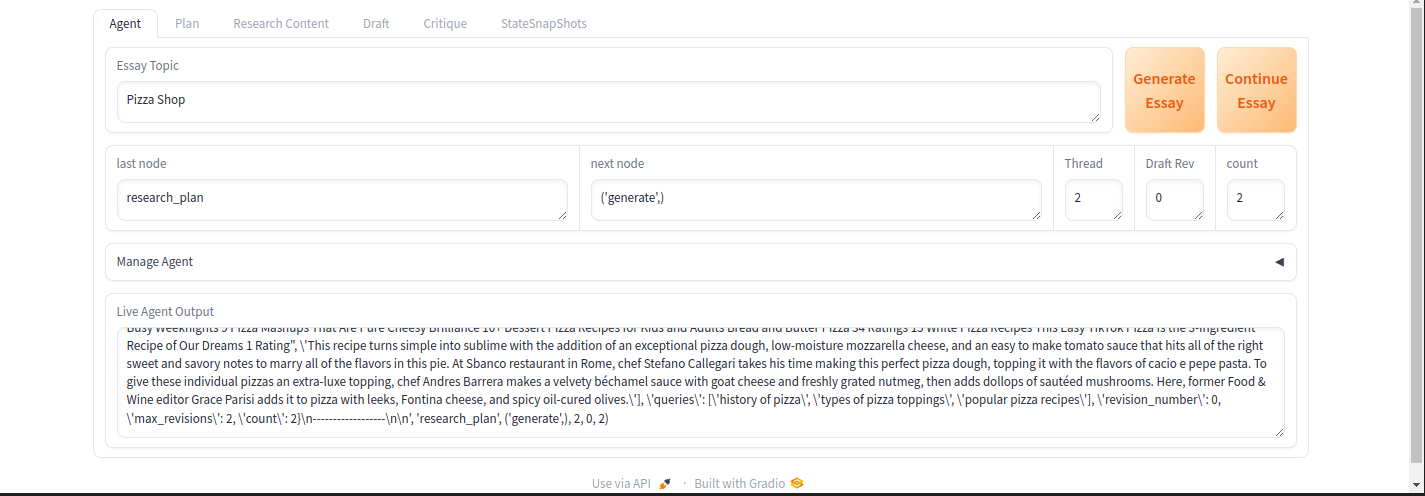